While CSV is simple and the most widely used data format (Excel, Google Sheets), there are several distinct advantages for Parquet, including:

* Parquet is column oriented and CSV is row oriented. Row-oriented formats are optimized for OLTP workloads while column-oriented formats are better suited for analytical workloads.
* Column-oriented databases such as AWS Redshift Spectrum bill by the amount data scanned per query
* Therefore, converting CSV to Parquet with partitioning and compression lowers overall costs and improves performance

In [49]:
#import os
#
#os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
#os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask
#
#os.environ["MODIN_ENGINE"] = "unidist" # Modin will use Unidist
#os.environ["UNIDIST_BACKEND"] = "mpi" # Unidist will use MPI backend
#
#import modin.pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Read the parquet file into a pandas dataframe
df = pd.read_parquet('SnowStorageDATA.parquet')
df

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
0,2023,1,1,0,0.06,0.00006,2023-01-01T00:00,5.4,2023.0,1.0,1.0,0.0,0.0,2023-01-01T00:00,25.6,7.1,2023-01-01T00:00,91
1,2023,1,1,1,0.03,0.00003,2023-01-01T01:00,5.2,2023.0,1.0,1.0,1.0,0.0,2023-01-01T01:00,24.1,6.7,2023-01-01T01:00,91
2,2023,1,1,2,0.02,0.00002,2023-01-01T02:00,5.1,2023.0,1.0,1.0,2.0,0.0,2023-01-01T02:00,24.8,6.9,2023-01-01T02:00,90
3,2023,1,1,3,0.01,0.00001,2023-01-01T03:00,4.8,2023.0,1.0,1.0,3.0,0.0,2023-01-01T03:00,23.8,6.6,2023-01-01T03:00,90
4,2023,1,1,4,0.01,0.00001,2023-01-01T04:00,4.4,2023.0,1.0,1.0,4.0,0.0,2023-01-01T04:00,23.4,6.5,2023-01-01T04:00,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,19,0.00,0.00000,2023-12-31T19:00,-5.6,NaN,NaN,NaN,NaN,NaN,2023-12-31T19:00,12.6,3.5,2023-12-31T19:00,80
8756,2023,12,31,20,0.00,0.00000,2023-12-31T20:00,-5.3,NaN,NaN,NaN,NaN,NaN,2023-12-31T20:00,11.2,3.1,2023-12-31T20:00,79
8757,2023,12,31,21,0.01,0.00001,2023-12-31T21:00,-5.6,NaN,NaN,NaN,NaN,NaN,2023-12-31T21:00,9.7,2.7,2023-12-31T21:00,80
8758,2023,12,31,22,0.02,0.00002,2023-12-31T22:00,-6.3,NaN,NaN,NaN,NaN,NaN,2023-12-31T22:00,6.8,1.9,2023-12-31T22:00,84


In [50]:
# Find the index where the first NaN value appears in the 'YEAR.1' column
first_nan_index = df['YEAR.1'].isna().idxmax()
first_nan_index

8736

In [51]:
# Drop all rows after the first NaN value in the 'YEAR.1' column
df_wo_nan = df.loc[:first_nan_index-1]
df_wo_nan

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
0,2023,1,1,0,0.06,0.00006,2023-01-01T00:00,5.4,2023.0,1.0,1.0,0.0,0.0,2023-01-01T00:00,25.6,7.1,2023-01-01T00:00,91
1,2023,1,1,1,0.03,0.00003,2023-01-01T01:00,5.2,2023.0,1.0,1.0,1.0,0.0,2023-01-01T01:00,24.1,6.7,2023-01-01T01:00,91
2,2023,1,1,2,0.02,0.00002,2023-01-01T02:00,5.1,2023.0,1.0,1.0,2.0,0.0,2023-01-01T02:00,24.8,6.9,2023-01-01T02:00,90
3,2023,1,1,3,0.01,0.00001,2023-01-01T03:00,4.8,2023.0,1.0,1.0,3.0,0.0,2023-01-01T03:00,23.8,6.6,2023-01-01T03:00,90
4,2023,1,1,4,0.01,0.00001,2023-01-01T04:00,4.4,2023.0,1.0,1.0,4.0,0.0,2023-01-01T04:00,23.4,6.5,2023-01-01T04:00,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,2023,12,30,19,0.11,0.00011,2023-12-30T19:00,0.0,2023.0,12.0,30.0,19.0,0.0,2023-12-30T19:00,25.2,7.0,2023-12-30T19:00,89
8732,2023,12,30,20,0.09,0.00009,2023-12-30T20:00,-0.4,2023.0,12.0,30.0,20.0,0.0,2023-12-30T20:00,25.9,7.2,2023-12-30T20:00,86
8733,2023,12,30,21,0.08,0.00008,2023-12-30T21:00,-0.8,2023.0,12.0,30.0,21.0,0.0,2023-12-30T21:00,23.8,6.6,2023-12-30T21:00,85
8734,2023,12,30,22,0.07,0.00007,2023-12-30T22:00,-1.0,2023.0,12.0,30.0,22.0,0.0,2023-12-30T22:00,23.4,6.5,2023-12-30T22:00,84


In [52]:
# Find the index where 'time.1' starts at '2023-04-01T00:00'
period_start_in = df[df['time.1'] == '2023-04-01T00:00'].index[0]

# Find the index where 'time.1' ends at '2023-05-01T00:00' (example stop period)
period_end_in = df[df['time.1'] == '2023-08-31T23:00'].index[0]

# Slice the DataFrame to include only the desired period
df_wo_nan_period = df_wo_nan.loc[period_start_in:period_end_in]

df_wo_nan_period

,YEAR,MO,DY,HR,PRECTOTCORR,Unnamed: 5,time,temperature_2m (°C),YEAR.1,MO.1,DY.1,HR.1,ALLSKY_SFC_SW_DWN,time.1,wind_speed_10m (km/h),Unnamed: 15,time.2,relative_humidity_2m (%)
2160,2023,4,1,0,0.00,0.00000,2023-04-01T00:00,0.2,2023.0,4.0,1.0,0.0,0.00,2023-04-01T00:00,21.6,6.0,2023-04-01T00:00,72
2161,2023,4,1,1,0.01,0.00001,2023-04-01T01:00,0.1,2023.0,4.0,1.0,1.0,0.00,2023-04-01T01:00,22.0,6.1,2023-04-01T01:00,75
2162,2023,4,1,2,0.01,0.00001,2023-04-01T02:00,-0.1,2023.0,4.0,1.0,2.0,0.00,2023-04-01T02:00,23.4,6.5,2023-04-01T02:00,65
2163,2023,4,1,3,0.01,0.00001,2023-04-01T03:00,-0.2,2023.0,4.0,1.0,3.0,0.00,2023-04-01T03:00,23.4,6.5,2023-04-01T03:00,77
2164,2023,4,1,4,0.00,0.00000,2023-04-01T04:00,-0.4,2023.0,4.0,1.0,4.0,34.09,2023-04-01T04:00,25.2,7.0,2023-04-01T04:00,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,2023,8,31,19,0.00,0.00000,2023-08-31T19:00,17.5,2023.0,8.0,31.0,19.0,0.00,2023-08-31T19:00,14.4,4.0,2023-08-31T19:00,86
5828,2023,8,31,20,0.00,0.00000,2023-08-31T20:00,17.1,2023.0,8.0,31.0,20.0,0.00,2023-08-31T20:00,14.8,4.1,2023-08-31T20:00,88
5829,2023,8,31,21,0.00,0.00000,2023-08-31T21:00,16.9,2023.0,8.0,31.0,21.0,0.00,2023-08-31T21:00,13.7,3.8,2023-08-31T21:00,91
5830,2023,8,31,22,0.01,0.00001,2023-08-31T22:00,16.5,2023.0,8.0,31.0,22.0,0.00,2023-08-31T22:00,13.0,3.6,2023-08-31T22:00,91


In [53]:
# Extract the air velocity column from the dataframe
df_air_vel = df_wo_nan_period.iloc[:, 15]
df_air_vel

2160    6.0
2161    6.1
2162    6.5
2163    6.5
2164    7.0
       ... 
5827    4.0
5828    4.1
5829    3.8
5830    3.6
5831    2.8
Name: Unnamed: 15, Length: 3672, dtype: float64

In [54]:
# Extract the air temperature column from the dataframe
df_air_temp = df_wo_nan_period.iloc[:, 7]
df_air_temp

2160     0.2
2161     0.1
2162    -0.1
2163    -0.2
2164    -0.4
        ... 
5827    17.5
5828    17.1
5829    16.9
5830    16.5
5831    15.8
Name: temperature_2m (°C), Length: 3672, dtype: float64

In [55]:
# Extract the amount of precipitation column from the dataframe
df_am_of_perc = df_wo_nan_period.iloc[:, 5] # m/h
df_am_of_perc

2160    0.00000
2161    0.00001
2162    0.00001
2163    0.00001
2164    0.00000
         ...   
5827    0.00000
5828    0.00000
5829    0.00000
5830    0.00001
5831    0.00001
Name: Unnamed: 5, Length: 3672, dtype: float64

---
$$
Q_{ground} = \lambda_{ground} A_{ground} \frac{\Delta T_g}{l}
$$

In [56]:
lam = 1.0 # W/(mK); thermal conductivity of the ground
A_ground = 210.0 # m^2; area of the ground
T1 = 0.0 # °C
T2 = 6.0 # °C
dT = T2 - T1
l = 1.0 # m; thickness of the ground
Q_ground = lam * A_ground * dT/l
print(f'The thermal heat energy from the ground is {Q_ground} W.')

The thermal heat energy from the ground is 1260.0 W.


---
$$Q_{melt} = \frac{Q_{ground}}{L_f \cdot \rho_{snow}}$$

In [57]:
L_f = 333.4E03 # J/kg; latent heat of fusion
rho_snow = 411.0 # kg/m^3; density of snow
# The rate of melted snow from ground melt
Q_melt = Q_ground/(L_f * rho_snow)
print(f'The rate of melted snow from ground melt is {Q_melt:.4e} m^3/s.')

The rate of melted snow from ground melt is 9.1952e-06 m^3/s.


---

In [58]:
# Total volume of melted snow due to ground melt
Q_melt_total = Q_melt * 3600 # m^3/h
print(f'The total volume of melted snow due to ground melt is {Q_melt_total:.4f} m^3/h.')

The total volume of melted snow due to ground melt is 0.0331 m^3/h.


In [59]:
df2 = pd.read_parquet('SurfaceMeltRateDATA.parquet')
df2

,G(h)_W/m2,Gb(n)_W/m2,Gd(h)_W/m2,IR(h)_W/m2,RH_%
0,0.00,0.0,0,306.98,72
1,0.00,0.0,0,311.56,75
2,0.00,0.0,0,316.14,65
3,0.00,0.0,0,320.72,77
4,34.09,0.0,0,325.31,78
...,...,...,...,...,...
3667,0.00,0.0,0,303.45,86
3668,0.00,0.0,0,308.59,88
3669,0.00,0.0,0,313.73,91
3670,0.00,0.0,0,318.88,91


Checking if the raw and snowmelt data are the same

In [60]:
# Relative humidity (%)
# Extract the columns to be compared
df_RH_temp = df_wo_nan_period.iloc[:, 17].reset_index(drop=True)
df2_RH = df2.iloc[:, 4].reset_index(drop=True)

# Determine the length of the shorter column
min_length = min(len(df_RH_temp), len(df2_RH))

# Compare the columns up to the length of the shorter column
not_equal_indices = df_RH_temp.iloc[:min_length] != df2_RH.iloc[:min_length]

# Display the rows and the values at each row where they are not equal
for index in not_equal_indices[not_equal_indices].index:
    print(f"Row {index}:")
    print(f"df_RH value: {df_RH_temp.iloc[index]}")
    print(f"df2 value: {df2_RH.iloc[index]}")
    print()

In [61]:
print(len(df_RH_temp))
print(len(df2_RH))

3672
3672


In [62]:
df_RH_temp

0       72
1       75
2       65
3       77
4       78
        ..
3667    86
3668    88
3669    91
3670    91
3671    93
Name: relative_humidity_2m (%), Length: 3672, dtype: int64

In [63]:
df2_RH

0       72
1       75
2       65
3       77
4       78
        ..
3667    86
3668    88
3669    91
3670    91
3671    93
Name: RH_%, Length: 3672, dtype: int64

In [64]:
# Surface melt rate G(h) W/m2
df_Gh = df_wo_nan_period['ALLSKY_SFC_SW_DWN']
df_Gh

2160     0.00
2161     0.00
2162     0.00
2163     0.00
2164    34.09
        ...  
5827     0.00
5828     0.00
5829     0.00
5830     0.00
5831     0.00
Name: ALLSKY_SFC_SW_DWN, Length: 3672, dtype: float64

In [65]:
# Heat transfer coefficient at the external surface
h = 22.7 # W/(m^2K)
# Solar light absorptivity
alpha = 0.8
# Correction factor for horizontal surface
T_cor_fact = 4.0 # °C
df_T_sol_air =  alpha * df_Gh / h + df_air_temp - T_cor_fact
df_T_sol_air

2160    -3.80000
2161    -3.90000
2162    -4.10000
2163    -4.20000
2164    -3.19859
          ...   
5827    13.50000
5828    13.10000
5829    12.90000
5830    12.50000
5831    11.80000
Length: 3672, dtype: float64

---
$$
Q_{surface} = A_{surface} \cdot \frac{\lambda_i}{d} \cdot \Delta T_s
$$

In [66]:
# Insulation layer thickness
d_ins = 0.1 # m
# Thermal conductivity for the insulating material
lam_i = 0.32 # W/(mK)
# The surface area (m2) of the pile of snow
A_surf = 210.0 # m^2
# The rate of heat transfer from the snow pile to the air
df_Q = A_surf * lam_i / d_ins * (df_T_sol_air - 0.0)    # W
df_Q

2160   -2553.600000
2161   -2620.800000
2162   -2755.200000
2163   -2822.400000
2164   -2149.452687
           ...     
5827    9072.000000
5828    8803.200000
5829    8668.800000
5830    8400.000000
5831    7929.600000
Length: 3672, dtype: float64

In [67]:
# The rate of melted snow from surface melt
df_f_melt_surf = df_Q/(L_f * rho_snow) # m^3/s
# Print the Series in scientific notation
formatted_series = df_f_melt_surf.apply(lambda x: f'{x:.4e}')
print(formatted_series)

2160    -1.8636e-05
2161    -1.9126e-05
2162    -2.0107e-05
2163    -2.0597e-05
2164    -1.5686e-05
           ...     
5827     6.6206e-05
5828     6.4244e-05
5829     6.3263e-05
5830     6.1302e-05
5831     5.7869e-05
Length: 3672, dtype: object


In [68]:
# Hourly rate of melted snow from surface melt
df_f_melt_surf_total = df_f_melt_surf * 3600 # m^3/h
#df_f_melt_surf_total.apply(lambda x: f'{x:.4f}')
df_f_melt_surf_total

2160   -0.067088
2161   -0.068854
2162   -0.072385
2163   -0.074150
2164   -0.056471
          ...   
5827    0.238341
5828    0.231279
5829    0.227748
5830    0.220686
5831    0.208327
Length: 3672, dtype: float64

In [69]:
rho_water = 1000 # kg/m^3
c_water = 4.19E03 # J/(kg * K)
# The heat flux from rain

# Initialize the Series with zeros
df_H_rain = pd.Series(0.0, index=df_air_temp.index)  # Initialize with float zeros

# Create a mask where air temperature is greater than 0
positive_temp_mask = df_air_temp > 0

# Calculate the heat flux where the air temperature is greater than 0
df_H_rain[positive_temp_mask] = df_am_of_perc[positive_temp_mask] * rho_water * c_water * df_air_temp[positive_temp_mask] / 3600.0

df_H_rain

2160    0.000000
2161    0.001164
2162    0.000000
2163    0.000000
2164    0.000000
          ...   
5827    0.000000
5828    0.000000
5829    0.000000
5830    0.192042
5831    0.183894
Length: 3672, dtype: float64

---
$$
v_{rain} = \frac{P A_{surf} \rho_{water} c_{water} T_{surroundings}}{L_{snow} \rho_{snow}}
$$

$P$ - percipitation

In [70]:
print(df_am_of_perc)
print(A_surf)
print(rho_water)
print(c_water)
print(df_air_temp)
print(L_f)
print(rho_snow)

2160    0.00000
2161    0.00001
2162    0.00001
2163    0.00001
2164    0.00000
         ...   
5827    0.00000
5828    0.00000
5829    0.00000
5830    0.00001
5831    0.00001
Name: Unnamed: 5, Length: 3672, dtype: float64
210.0
1000
4190.0
2160     0.2
2161     0.1
2162    -0.1
2163    -0.2
2164    -0.4
        ... 
5827    17.5
5828    17.1
5829    16.9
5830    16.5
5831    15.8
Name: temperature_2m (°C), Length: 3672, dtype: float64
333400.0
411.0


In [71]:
df_v_rain = df_am_of_perc * A_surf * rho_water * c_water * df_air_temp / (L_f * rho_snow) # m^3/h
df_v_rain.apply(lambda x: f'{x:.4e}')

2160     0.0000e+00
2161     6.4213e-06
2162    -6.4213e-06
2163    -1.2843e-05
2164    -0.0000e+00
           ...     
5827     0.0000e+00
5828     0.0000e+00
5829     0.0000e+00
5830     1.0595e-03
5831     1.0146e-03
Length: 3672, dtype: object

In [72]:
# Initialize the Series with zeros for  SMR
df_SMR_temp = pd.Series(0.0, index=df_air_temp.index)  # Initialize with float zeros

# Create a mask where air temperature is greater than 0
smr_temp_mask = df_air_temp > 0.0

# Calculate the surface melt rate where the temperature is greater than 0
df_SMR_temp[smr_temp_mask] = df_f_melt_surf_total[smr_temp_mask] * rho_snow / A_surf

df_SMR_temp


2160   -0.131302
2161   -0.134757
2162    0.000000
2163    0.000000
2164    0.000000
          ...   
5827    0.466467
5828    0.452645
5829    0.445735
5830    0.431914
5831    0.407726
Length: 3672, dtype: float64

In [73]:
df_SMR_rain = df_v_rain * rho_snow / A_surf # m^3/h
df_SMR_rain

2160    0.000000
2161    0.000013
2162   -0.000013
2163   -0.000025
2164   -0.000000
          ...   
5827    0.000000
5828    0.000000
5829    0.000000
5830    0.002074
5831    0.001986
Length: 3672, dtype: float64

In [74]:
df_SMR_total = df_SMR_temp + df_SMR_rain
df_SMR_total

2160   -0.131302
2161   -0.134744
2162   -0.000013
2163   -0.000025
2164    0.000000
          ...   
5827    0.466467
5828    0.452645
5829    0.445735
5830    0.433987
5831    0.409712
Length: 3672, dtype: float64

In [75]:
# Cumulative sum of the total surface melt rate
df_SMR_total_cumsum = df_SMR_total.cumsum()
df_SMR_total_cumsum

2160      -0.131302
2161      -0.266046
2162      -0.266059
2163      -0.266084
2164      -0.266084
           ...     
5827    2438.426695
5828    2438.879340
5829    2439.325075
5830    2439.759062
5831    2440.168774
Length: 3672, dtype: float64

---
$$
SMR = -0.09 + 0.00014 \cdot P_{solar} + 0.0575 \cdot T_{air} + 0.0012 \cdot T_{air} \cdot u_{air} - 0.18 \cdot T_{air} \cdot Z
$$

In [76]:
df_P_solar = df_Gh
# Surface melt rate from solar radiation, air temperature, air velocity, and insulation thickness
df_SMR_ins1 = -0.09 + 0.00014 * df_P_solar + 0.0575*df_air_temp + 0.0012*df_air_temp*df_air_vel - 0.18*df_air_temp*d_ins # kg/m2/h
df_SMR_ins1

2160   -0.080660
2161   -0.085318
2162   -0.094730
2163   -0.099460
2164   -0.104387
          ...   
5827    0.685250
5828    0.669582
5829    0.654614
5830    0.633030
5831    0.587188
Length: 3672, dtype: float64

In [77]:
def Psat_WV(T_K):
    """
    Water vapour saturation pressure
    W. Wagner and A. Pruß:" The IAPWS Formulation 1995 for the
    Thermodynamic Properties of Ordinary Water Substance for General and Scientific Use ",
    Journal of Physical and Chemical Reference Data, June 2002 ,Volume 31, Issue 2, pp.
    387535)

    Returns Saturation vapor pressure (hPa)
    """
    Tc = 647.096  # Critical temperature, K
    Pc = 220640   # Critical pressure, hPa
    
    C1 = -7.85951783
    C2 = 1.84408259
    C3 = -11.7866497
    C4 = 22.6807411
    C5 = -15.9618719
    C6 = 1.80122502
    
    teta = 1 - T_K / Tc
    
    x = Tc / T_K * (C1 * teta + C2 * teta ** 1.5 + C3 * teta ** 3 + C4 * teta ** 3.5 + C5 * teta ** 4 + C6 * teta ** 7.5)
    
    x = np.exp(x) * Pc
    
    return x

# Example usage:
#T_K = 300  # Example temperature in Kelvin
#print(f"Saturation vapor pressure at {T_K} K is {Psat_WV(T_K)} hPa")

In [78]:
#%%timeit
df_Psat = Psat_WV(df_air_temp + 273.15)/10 # hPa; 100/1000 to convert to hPa
df_Psat

2160    0.620152
2161    0.615668
2162    0.606786
2163    0.602388
2164    0.593677
          ...   
5827    2.000549
5828    1.950561
5829    1.925980
5830    1.877632
5831    1.795581
Name: temperature_2m (°C), Length: 3672, dtype: float64

In [79]:
df_RH_perc = df_wo_nan_period.iloc[:, 17]
df_RH_perc

2160    72
2161    75
2162    65
2163    77
2164    78
        ..
5827    86
5828    88
5829    91
5830    91
5831    93
Name: relative_humidity_2m (%), Length: 3672, dtype: int64

In [80]:
df_Psat

2160    0.620152
2161    0.615668
2162    0.606786
2163    0.602388
2164    0.593677
          ...   
5827    2.000549
5828    1.950561
5829    1.925980
5830    1.877632
5831    1.795581
Name: temperature_2m (°C), Length: 3672, dtype: float64

In [81]:
# Water steam pressure
df_Pw = df_Psat*df_RH_perc/100.0 # kPa
df_Pw

2160    0.446509
2161    0.461751
2162    0.394411
2163    0.463839
2164    0.463068
          ...   
5827    1.720472
5828    1.716493
5829    1.752642
5830    1.708645
5831    1.669890
Length: 3672, dtype: float64

In [82]:
# Absolute humidity
df_w = 2.16679*df_Pw*1000/(273.15+df_air_temp) # kPa; 1000 to convert to kPa
df_w

2160     3.539389
2161     3.661546
2162     3.129852
2163     3.682145
2164     3.678720
          ...    
5827    12.826084
5828    12.814059
5829    13.092937
5830    12.781892
5831    12.522243
Length: 3672, dtype: float64

In [83]:
def Psat_WV_vectorized(T_K):
    """
    Water vapour saturation pressure
    W. Wagner and A. Pruß:" The IAPWS Formulation 1995 for the
    Thermodynamic Properties of Ordinary Water Substance for General and Scientific Use ",
    Journal of Physical and Chemical Reference Data, June 2002 ,Volume 31, Issue 2, pp.
    387535)

    Returns Saturation vapor pressure (hPa)
    """
    Tc = 647.096  # Critical temperature, K
    Pc = 220640   # Critical pressure, hPa
    
    C1 = -7.85951783
    C2 = 1.84408259
    C3 = -11.7866497
    C4 = 22.6807411
    C5 = -15.9618719
    C6 = 1.80122502
    
    teta = 1 - T_K / Tc
    
    x = Tc / T_K * (C1 * teta + C2 * np.power(teta, 1.5) + C3 * np.power(teta, 3) + C4 * np.power(teta, 3.5) + C5 * np.power(teta, 4) + C6 * np.power(teta, 7.5))
    
    x = np.exp(x) * Pc
    
    return x

# Example usage with a pandas DataFrame
#data = {'Temperature_K': [300, 310, 320, 330, 340]}  # Example temperatures in Kelvin
#df = pd.DataFrame(data)
#df['Saturation_Vapor_Pressure_hPa'] = Psat_WV_vectorized(df['Temperature_K'])

print(df)

      YEAR  MO  DY  HR  PRECTOTCORR  Unnamed: 5              time  \
0     2023   1   1   0         0.06     0.00006  2023-01-01T00:00   
1     2023   1   1   1         0.03     0.00003  2023-01-01T01:00   
2     2023   1   1   2         0.02     0.00002  2023-01-01T02:00   
3     2023   1   1   3         0.01     0.00001  2023-01-01T03:00   
4     2023   1   1   4         0.01     0.00001  2023-01-01T04:00   
...    ...  ..  ..  ..          ...         ...               ...   
8755  2023  12  31  19         0.00     0.00000  2023-12-31T19:00   
8756  2023  12  31  20         0.00     0.00000  2023-12-31T20:00   
8757  2023  12  31  21         0.01     0.00001  2023-12-31T21:00   
8758  2023  12  31  22         0.02     0.00002  2023-12-31T22:00   
8759  2023  12  31  23         0.04     0.00004  2023-12-31T23:00   

      temperature_2m (°C)  YEAR.1  MO.1  DY.1  HR.1  ALLSKY_SFC_SW_DWN  \
0                     5.4  2023.0   1.0   1.0   0.0                0.0   
1                     5

In [84]:
#%%timeit
df_Psat_vec = Psat_WV_vectorized(df_air_temp + 273.15) # hPa
df_Psat_vec

2160     6.201519
2161     6.156680
2162     6.067863
2163     6.023882
2164     5.936768
          ...    
5827    20.005488
5828    19.505606
5829    19.259798
5830    18.776320
5831    17.955812
Name: temperature_2m (°C), Length: 3672, dtype: float64

---
$$
SMR = -0.97 - 0.097 \cdot Z + 0.164 \cdot u_{air} + 0.00175 \cdot i_{light} + 0.102 \cdot T_{air} + 0.192 \cdot AH
$$

In [85]:
#print(d_ins)
#print(df_air_temp)
#print(df_Gh)
#print(df_air_temp)
print(df_w)

2160     3.539389
2161     3.661546
2162     3.129852
2163     3.682145
2164     3.678720
          ...    
5827    12.826084
5828    12.814059
5829    13.092937
5830    12.781892
5831    12.522243
Length: 3672, dtype: float64


In [86]:
df_air_vel[1:2]

2161    6.1
Name: Unnamed: 15, dtype: float64

In [87]:
# Some weird rounding error?
#-0.97-0.097*(d_ins*100)+0.164*df_air_vel+0.00175*df_Gh+0.102*(df_air_temp)+0.192*df_w
-0.97 - 0.097*0.1*100 + 0.164*6.1 + 0.00175*0.0 + 0.102*0.1 + 0.192*3.661546


-0.22638316800000002

In [88]:
# Surface melt rate from insulation thickness, air velocity, light intensity, air temperature and air humidity
df_SMR_ins2 = -0.97 - 0.097*(d_ins*100) + 0.164*df_air_vel + 0.00175*df_Gh + 0.102*df_air_temp + 0.192*df_w # kg/m2/h
df_SMR_ins2

2160   -0.256037
2161   -0.226383
2162   -0.283268
2163   -0.187428
2164   -0.066828
          ...   
5827    2.963608
5828    2.936899
5829    2.920844
5830    2.787523
5831    2.535071
Length: 3672, dtype: float64

In [89]:
#%%timeit
# Fastest method
# Applying the condition using the np.where() function and storing the result in a new Series object
df_SMR_ins1_cond = pd.Series(np.where((df_SMR_ins1 < 0) | (df_air_temp < 0), 0, df_SMR_ins1))
df_SMR_ins1_cond

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    0.685250
3668    0.669582
3669    0.654614
3670    0.633030
3671    0.587188
Length: 3672, dtype: float64

In [90]:
#%%timeit
## Applying the condition using mask
#df_SMR_ins1_cond = df_SMR_ins1.mask((df_SMR_ins1 < 0) | (df_air_temp < 0), 0)
#df_SMR_ins1_cond

In [91]:
#%%timeit
## Applying the condition
#df_SMR_ins1_cond = df_SMR_ins1.where((df_SMR_ins1 >= 0) & (df_air_temp >= 0), 0)
#df_SMR_ins1_cond

In [92]:
df_SMR_ins2

2160   -0.256037
2161   -0.226383
2162   -0.283268
2163   -0.187428
2164   -0.066828
          ...   
5827    2.963608
5828    2.936899
5829    2.920844
5830    2.787523
5831    2.535071
Length: 3672, dtype: float64

In [93]:
# Applying the condition using the np.where() function and storing the result in a new Series object
df_SMR_ins2_cond = pd.Series(np.where((df_SMR_ins2 < 0) | (df_air_temp < 0), 0, df_SMR_ins2))
df_SMR_ins2_cond

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
          ...   
3667    2.963608
3668    2.936899
3669    2.920844
3670    2.787523
3671    2.535071
Length: 3672, dtype: float64

In [94]:
df_SMR_ins1_cond_cumsum = df_SMR_ins1_cond.cumsum()
df_SMR_ins2_cond_cumsum = df_SMR_ins2_cond.cumsum()
display(df_SMR_ins1_cond_cumsum)
display(df_SMR_ins2_cond_cumsum)

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
3667    2213.013906
3668    2213.683488
3669    2214.338102
3670    2214.971132
3671    2215.558320
Length: 3672, dtype: float64

0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
           ...     
3667    8181.811551
3668    8184.748450
3669    8187.669294
3670    8190.456817
3671    8192.991888
Length: 3672, dtype: float64

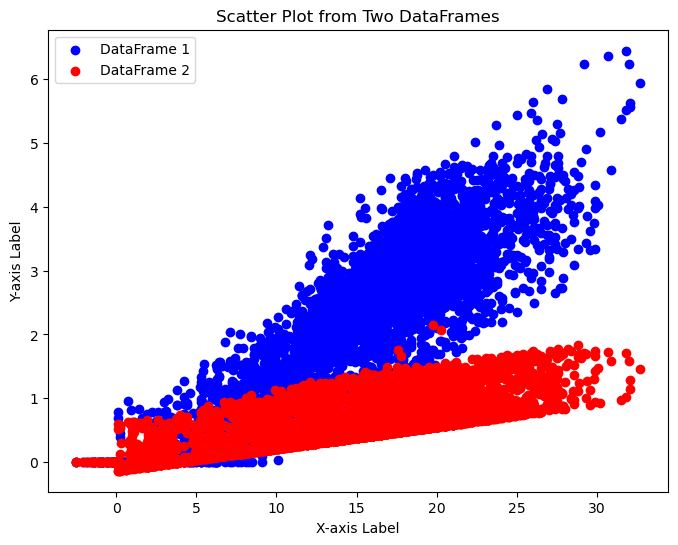

In [95]:

# Generate the scatter plot
plt.figure(figsize=(8, 6))

# Plot data from the first DataFrame
plt.scatter(df_air_temp, df_SMR_ins2_cond, color='blue', label='DataFrame 1')

# Plot data from the second DataFrame
plt.scatter(df_air_temp, df_SMR_total, color='red', label='DataFrame 2')

plt.title('Scatter Plot from Two DataFrames')
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.legend()
plt.show()

In [96]:
df3 = pd.read_parquet('TsiTsoDATA.parquet')
df3

,Tsi_C,Tso_C
0,-1.211547e-35,-0.422381
1,-1.349124e-29,-0.715959
2,-4.325687e-26,-0.960885
3,-1.230188e-23,-1.149471
4,-9.227676e-22,-1.188722
...,...,...
3667,6.614035e-01,15.125034
3668,6.612097e-01,14.919390
3669,6.610148e-01,14.754398
3670,6.608188e-01,14.597013
